In [38]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print('torch ver: ', torch.__version__)

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
image, label = trainset[0] 
print("image shape: ", image.shape) # torch.Size([1, 28, 28])
print("# labels: ", len(testset.classes))
print(testset.class_to_idx)

torch ver:  2.0.0
image shape:  torch.Size([1, 28, 28])
# labels:  10
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [39]:
# Final sizes are 50000, 10000, 10000
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')
# Shuffle the data at the start of each epoch (only useful for training set)
batchsize = 128 # was 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

Train set size: 50000, Validation set size: 10000, Test set size: 10000


MPS is built? True
k=10


/Users/johnheo/miniforge3/envs/499/lib/python3.9/site-packages/torch/functional.py:799: UserWarning: MPS: _unique2 op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:354.)
  output, inverse_indices, counts = torch._unique2(
/Users/johnheo/miniforge3/envs/499/lib/python3.9/site-packages/fast_pytorch_kmeans/kmeans.py:192: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  c_grad[c_grad!=c_grad] = 0 # remove NaNs


used 70 iterations (1.8262s) to cluster 50000 items into 10 clusters
Visualize the centroids...


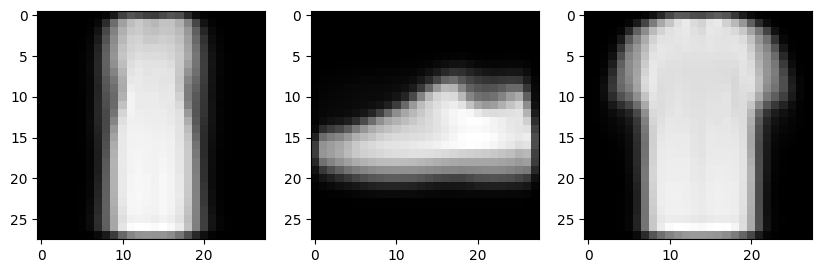

Centroids saved to ./centroids/torch-k=10.pt (shape: (10, 784))


In [40]:
# kmeans clustering on train data
from utils.cluster import get_centroids

print("MPS is built?", torch.backends.mps.is_built())
k_list = [10, 20, 40, 80, 160]
k_list = [10]
d = 'cpu'
d = 'mps'
for n_clusters in k_list:
    print(f"k={n_clusters}")
    kmeans, centroids = get_centroids(n_clusters, train_loader, device=d, save=True, vis=True)

sklearn_execution = {
    'k=10': ":35",
    'k=20': "1:31",
    'k=40': "3:26",
    'k=80': "7:38",
    'k=160': "14:30",
}
torch_execution = { # super fast with parallelism using mps backend (m1x chip)
    'k=10': ":01",
    'k=20': ":02",
    'k=40': ":06",
    'k=80': ":11",
    'k=160': ":21",
}

In [41]:
# check if file exists with the substring k=10
import os
DIR = './centroids'
SAVENAME = f'{DIR}/torch-k={n_clusters}.pt'
if os.path.exists(SAVENAME):
    centroids = torch.load(SAVENAME)


In [42]:
import numpy as np

# flatten the tensor except batch dim
flatten = lambda x : x.view(x.size(0), -1).numpy()
# which image is assigned to which cluster?
assignments = []
for image, target in train_loader:
    feat = flatten(image)
    closest = np.argmax(centroids @ feat.T, axis=0)
    assignments.extend(closest)

In [43]:
# create a nested list according to assignments
def fetch(data_loader, indices):
    all_data = list(data_loader.dataset)  # Convert the dataset to a list
    fetched_images = [all_data[i] for i in indices]
    return fetched_images

clustered_dataset = [[] for i in range(10)]

for i in range(10):
    idx = np.where(np.array(assignments) == i)[0]
    print(f"cluster {i} has {len(idx)} images")
    imgs = fetch(train_loader, idx)
    clustered_dataset[i] = imgs


cluster 0 has 3635 images
cluster 1 has 9637 images
cluster 2 has 6841 images
cluster 3 has 3820 images
cluster 4 has 4821 images
cluster 5 has 12 images
cluster 6 has 9006 images
cluster 7 has 8582 images
cluster 8 has 1559 images
cluster 9 has 2087 images


In [44]:
#for creating custom dataset
from torch.utils.data import Dataset

class DictDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
        self.keys = list(data_dict.keys())
        self.keys.sort()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        # Get the image data and label for the current item
        key = self.keys[index]
        img = self.data_dict[key]['images']
        label = self.data_dict[key]['labels']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [45]:
import random
#create dataset with 50% of data
data_dict_50 = {}
index = 0
for i in range(10):
    num_items = len(clustered_dataset[i])
    num_selected = len(clustered_dataset[i])/2
    #select random indices
    selected_indices = random.sample(range(num_items), int(num_selected))
    for j in selected_indices:
        data_dict_50[index] = {'images': clustered_dataset[i][j][0], 'labels': clustered_dataset[i][j][1]}
        index = index+1

print(len(data_dict_50))

custom_dataset = DictDataset(data_dict_50)
# Create the dataloader for the train dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=128, shuffle=True)

24997


In [46]:
# visualize histogram 
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(assignments):
    plt.hist(assignments, bins=10)
    plt.xlabel("Cluster")
    plt.ylabel("Number of images")
    plt.title("Histogram of clusters")
    plt.show()

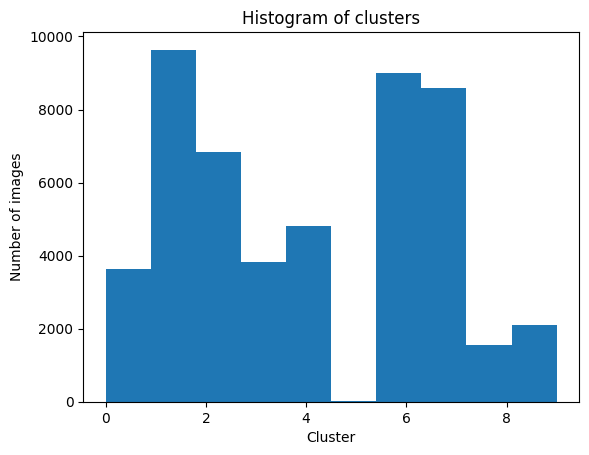

In [47]:
plot_histogram(assignments)